# Air Passenger Time Series Analysis

For this analysis, we wish to predict the number of passengers in every month from 1959 to 1960 using the data from 1949 to 1958 as a training dataset

In [127]:
# Import Packages
import pandas as pd
import statistics
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMA as ARIMA2
import matplotlib.pylab as plt 
%matplotlib inline             

In [2]:
# Read in dataset
air = pd.read_csv('AirPassengers.csv')
air.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


# Initial EDA of Data

We will plot the data to see what patterns it has and to find out if it is stationary or not

<AxesSubplot:title={'center':'Number of Passengers by Month'}, xlabel='Month', ylabel='Number of Passengers'>

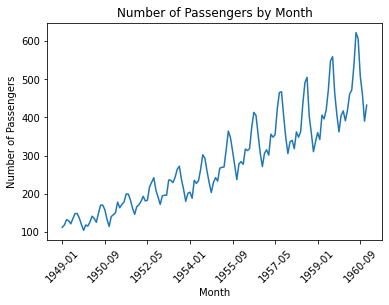

In [3]:
air.plot(kind = 'line',
          x = 'Month',
          y = '#Passengers',
          legend = False,
          title = 'Number of Passengers by Month',
          rot = 45,
          ylabel = 'Number of Passengers')

From the plot we can see the the data is clearly not stationary, as the mean and variance are not constant and there is an upward trend in the data. We can also graph the histogram of the data and see that it is right skewed:

<AxesSubplot:ylabel='Frequency'>

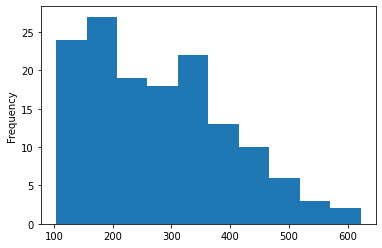

In [4]:
air["#Passengers"].plot(kind = 'hist',
          x = '#Passengers')  

# Make the Data Stationary

If we transform the data using a log transform we can see that the data takes a more gaussian looking distribution

<AxesSubplot:ylabel='Frequency'>

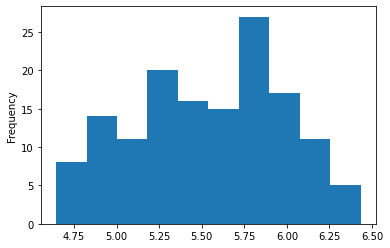

In [5]:
air['passengers_log'] = np.log(air["#Passengers"])

air.passengers_log.plot(kind = 'hist',
          x = '#Passengers') 

If we graph the data again on the log scale, it is starting to become more stationary, but there is still a trend.

<AxesSubplot:title={'center':'Log Number of Passengers by Month'}, xlabel='Month', ylabel='Log Number of Passengers'>

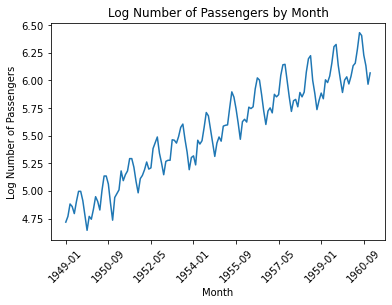

In [6]:
air.plot(kind = 'line',
          x = 'Month',
          y = 'passengers_log',
          legend = False,
          title = 'Log Number of Passengers by Month',
          rot = 45,
          ylabel = 'Log Number of Passengers')

Looking at the means and standard deviations of each half of the data, we can see that the means are slightly different but not too far off and the standard deviations are almost the same. 

In [7]:
index_half = int(air.shape[0]/2)
group_1 = air.passengers_log[:index_half]
group_2 = air.passengers_log[index_half:]

In [8]:
print('Group_1 mean:',statistics.mean(group_1))
print('Group_2 mean:',statistics.mean(group_2))
print('Group_1 stdev:',statistics.stdev(group_1))
print('Group_2 stdev:',statistics.stdev(group_2))

Group_1 mean: 5.17514614000377
Group_2 mean: 5.909205777059973
Group_1 stdev: 0.26332088210605353
Group_2 stdev: 0.22351298763220206


In order to truly see if the data is stationary or not, we can use the ad fuller test. If we receive a p-value less than 0.05, we can say the data is stationary.

In [9]:
adf_results = adfuller(air["#Passengers"])

In [10]:
adf_results

(0.8153688792060465,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

Based on the ad fuller test, we can see that our data is still not stationary, so we will have to do soem more tweaking. We will use a difference of 1 to see if it helps make the data more stationary.

In [11]:
# Use differencing function to get difference of 1
air['passenger_diff_1'] = air["#Passengers"].diff(1)

<AxesSubplot:title={'center':'Difference-1 Passengers'}, xlabel='Month', ylabel='Difference-1 Number of Passengers'>

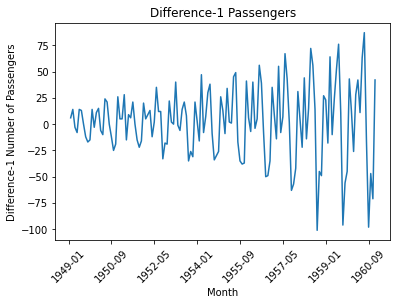

In [12]:
# Plot results of differencing
air.plot(kind = 'line',
          x = 'Month',
          y = 'passenger_diff_1',
          legend = False,
          title = 'Difference-1 Passengers',
          rot = 45,
          ylabel = 'Difference-1 Number of Passengers')

The trend in the data seems to be gone now and the mean seems to be constant, but the variance seems to fluctuate still. We can use the ad fuller test again to check if it is stationary:

In [13]:
adf_results = adfuller(air.passenger_diff_1[2:])
adf_results

(-2.8334256455653137,
 0.05365549915891035,
 12,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 980.990262745086)

The data is now much more stationary, but still not below our desired p-value of 0.05. We can take the difference of the log of the passengers to see if it will make it more stationary:

In [14]:
# Use differencing function on the log of passenger data
air['log_passenger_diff_1'] = air.passengers_log.diff(1)

<AxesSubplot:title={'center':'Log Difference-1 Number of Passengers'}, xlabel='Month', ylabel='Log Difference-1 Number of Passengers'>

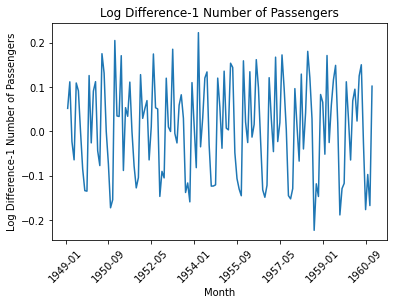

In [15]:
# Graph log differencing data
air.plot(kind = 'line',
          x = 'Month',
          y = 'log_passenger_diff_1',
          legend = False,
          title = 'Log Difference-1 Number of Passengers',
          rot = 45,
          ylabel = 'Log Difference-1 Number of Passengers')

The data seems stationary by looking at the graph, with the variance now looking constant. We will use the ad fuller test one more time to make sure:

In [16]:
adf_results = adfuller(air.log_passenger_diff_1[2:])
adf_results

(-2.877448565571073,
 0.048033972528753376,
 14,
 127,
 {'1%': -3.482920063655088,
  '5%': -2.884580323367261,
  '10%': -2.5790575441750883},
 -438.0301403616031)

Our p-value is below 0.05, which means we can reject the null in favor of the alternative hypothesis. This means we can now say our data is stationary

# ACF and PACF Plots

Now we will look at our ACF and PACF plots to determine the order of our ARIMA model

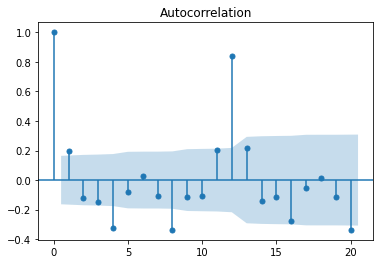

In [17]:
# Create ACF plot
acf = plot_acf(air['log_passenger_diff_1'][1:], lags = 20)

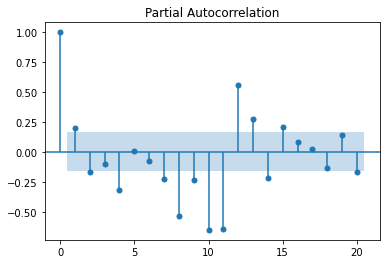

In [18]:
# Create PACF plot
pacf = plot_pacf(air['log_passenger_diff_1'][1:], lags=20)

Based on these plots, there could be multiple different models that would work best. I will try AR(1), MA(1), ARMA(1,1), and ARMA(4,4)

# Test Different Models

First we can create a training and test set

In [78]:
two_months = int(len(air["#Passengers"]) - 24)
train = air["#Passengers"][:two_months]
test = air["#Passengers"][two_months]


# Fit AR(1) with First Order Differencing 

In [79]:
model = ARIMA(train, order=(1,1,0))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  120
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -563.328
Date:                Tue, 10 Nov 2020   AIC                           1130.656
Time:                        22:05:55   BIC                           1136.215
Sample:                             0   HQIC                          1132.913
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2858      0.093      3.074      0.002       0.104       0.468
sigma2       756.7940     80.855      9.360      0.000     598.321     915.267
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 5.61
Prob(Q):                              0.49   Prob(JB):                         0.06
Heteroskedasticity (H):               7.21   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Fit MA(1) with First Order Differencing

In [80]:
model1 = ARIMA(train, order=(0,1,1))
fit_model1 = model1.fit()
fit_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  120
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -561.510
Date:                Tue, 10 Nov 2020   AIC                           1127.020
Time:                        22:05:58   BIC                           1132.578
Sample:                             0   HQIC                          1129.277
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3824      0.094      4.076      0.000       0.199       0.566
sigma2       733.5500     81.729      8.975      0.000     573.364     893.736
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 3.56
Prob(Q):                              0.77   Prob(JB):                         0.17
Heteroskedasticity (H):               7.04   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Fit AR 1 and MA 1 with First Order Differencing

In [81]:
model2 = ARIMA(train, order=(1,1,1))
fit_model2 = model2.fit()
fit_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -559.714
Date:                Tue, 10 Nov 2020   AIC                           1125.429
Time:                        22:06:02   BIC                           1133.766
Sample:                             0   HQIC                          1128.814
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5120      0.148     -3.469      0.001      -0.801      -0.223
ma.L1          0.8746      0.097      8.977      0.000       0.684       1.066
sigma2       709.3300     83.383      8.507      0.000     545.903     872.757
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 3.60
Prob(Q):                              0.69   Prob(JB):                         0.16
Heteroskedasticity (H):               6.95   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Fit AR 4 and MA 4 with First Order Differencing

In [167]:
model3 = ARIMA(train, order=(4,1,4))
fit_model3 = model3.fit()
fit_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  120
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -534.714
Date:                Tue, 10 Nov 2020   AIC                           1087.428
Time:                        22:42:49   BIC                           1112.440
Sample:                             0   HQIC                          1097.585
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0322      0.097      0.333      0.739      -0.157       0.222
ar.L2          0.9675      0.083     11.690      0.000       0.805       1.130
ar.L3         -0.1227      0.077     -1.587      0.113      -0.274       0.029
ar.L4         -0.7242      0.097     -7.480      0.000      -0.914      -0.534
ma.L1         -0.0804      0.159     -0.505      0.613      -0.392       0.232
ma.L2         -1.5216      0.141    -10.814      0.000      -1.797      -1.246
ma.L3          0.0594      0.161      0.369      0.712      -0.256       0.375
ma.L4          0.9160      0.162      5.654      0.000       0.598       1.233
sigma2       435.4827     84.757      5.138      0.000     269.361     601.604
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 3.01
Prob(Q):                              0.78   Prob(JB):                         0.22
Heteroskedasticity (H):               5.19   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model with ARMA(4,4) was the model with the lowest AIC that I tested, so I will use this as my model.

# Use Best Model to Forcast into The Future

Use this test set for final predictions:

In [119]:
# create subset of number of days we want to predict for
forecasts_to_predict = air.shape[0] - two_months
print(forecasts_to_predict)

24


In [120]:
# Create predictions for the number of days we selected above
m3_forecasts = fit_model3.forecast(forecasts_to_predict)

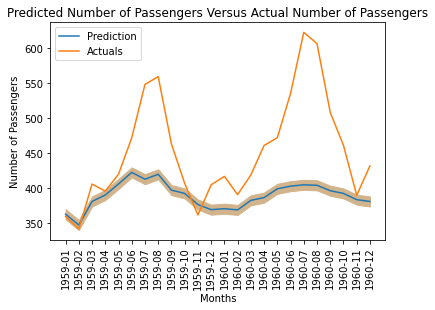

In [168]:
# Create graph of predictions along with actual values to compare the difference
#Plot Predictions
reg_and_forecasts = train.tolist() + m3_forecasts.tolist()
a1 = plt.plot(air['Month'][two_months:],
              reg_and_forecasts[two_months:],
              label = 'Prediction')

plt.xticks(rotation = 90)

# Plot Actual Values
plt.plot(air['Month'][two_months:],
         air['#Passengers'][two_months:],
         label = 'Actuals')

# Plot 95% Confidence Interval
Lower = reg_and_forecasts[two_months:] - 1.960*(np.std(reg_and_forecasts[two_months:]) / np.sqrt(len(reg_and_forecasts[two_months:])))
Upper = reg_and_forecasts[two_months:] + 1.960*(np.std(reg_and_forecasts[two_months:]) / np.sqrt(len(reg_and_forecasts[two_months:])))

x = np.arange(0,24,1)
plt.fill_between(x, Lower, Upper, color = 'tan')

# Labels and cosmetics
plt.legend(loc = 'best')
plt.xlabel("Months")
plt.ylabel("Number of Passengers")
plt.title("Predicted Number of Passengers Versus Actual Number of Passengers")
plt.show()

We can see that our model has created predictions for each of the months form the beginning of 1959 to the end of 1960. It seems to fluctuate up and down just like the actual values, but much more muted. To get a better idea of the predictions, we will plot the last four years of data along with our prediction form the ARIMA model:

In [162]:
# Show prediction in comparison to all data
# Create a forecast from the beginning of 1959 to the end of 1960 (24 months)
forecast = fit_model3.predict(start = air.shape[0] - 24,  
                          end = (air.shape[0]),  
                          typ = 'levels').rename('Forecast') 

Text(0.5, 1.0, 'Predicted Number of Passengers Versus Actual Number of Passengers')

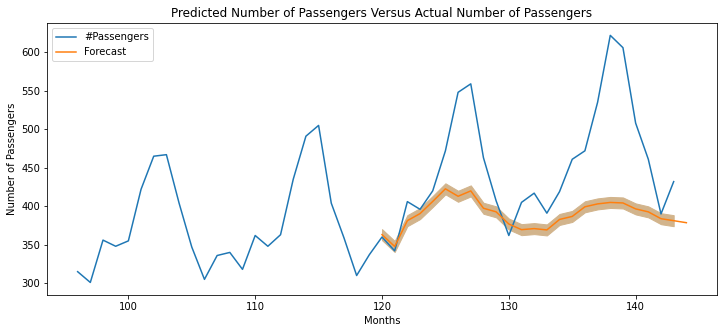

In [164]:
# Plot last 4 years of data along with predictions
air['#Passengers'][96:].plot(figsize = (12, 5), legend = True) 
forecast.plot(legend = True) 

# Plot Confidence Interval
x = np.arange(120,144,1)
plt.fill_between(x, Lower, Upper, color = 'tan')

# Add Labels
plt.xlabel("Months")
plt.ylabel("Number of Passengers")
plt.title("Predicted Number of Passengers Versus Actual Number of Passengers")

The prediction line does not seem to be the most accurate. For example, it predicts that the number of passengers for July of 1960 is around 400, but the actual value is 622, this is over a 200 passenger difference. There could be a better model that would be more effective in computing the predicted values, we would need to play around with it. It seems that higher orders in the ARIMA model for this data produce better results, however I know it is common practice to try and keep the orders as low as possible, which is why I tried a more conservative order.